In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, f1_score

from xgboost import XGBRegressor

import lightgbm as lgb

from scipy.optimize import minimize

from IPython.display import clear_output, display

from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Data Exploration and Preprocessing

In [2]:
# Variables
file_path = 'airflow/dags/assets/matches-checkpoint.csv'
spanish_squads = ['Sevilla', 'Sporting Huelva', 'Athletic Club', 'Levante Planas',
                  'UDG Tenerife', 'Villarreal', 'Madrid CFF', 'Barcelona',
                  'Atlético Madrid', 'Real Madrid', 'Alhama', 'Alavés',
                  'Real Sociedad', 'Levante', 'Real Betis', 'Valencia']
useless_columns= [ 'Home_id', 'Away_id', 'Match_id', 'League_id']

In [3]:
# Load the data
matches = pd.read_csv(file_path)
matches = matches.drop(columns=useless_columns)

# Drop the rows in which the home or away team is not a spanish team
matches = matches[matches['Home'].isin(spanish_squads) | matches['Away'].isin(spanish_squads)]

display(matches.describe(), matches.sample(3), matches.info(), matches.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wk         87 non-null     int64  
 1   Day        87 non-null     object 
 2   Date       87 non-null     object 
 3   Time       87 non-null     object 
 4   Home       87 non-null     object 
 5   xGHome     87 non-null     float64
 6   Score      87 non-null     object 
 7   xGAway     87 non-null     float64
 8   Away       87 non-null     object 
 9   xPHome     87 non-null     float64
 10  xPAway     87 non-null     float64
 11  ScoreHome  87 non-null     int64  
 12  ScoreAway  87 non-null     int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 9.5+ KB


,Wk,xGHome,xGAway,xPHome,xPAway,ScoreHome,ScoreAway
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,6.034483,1.406897,1.266667,1.448046,1.333103,1.643678,1.643678
std,3.182248,1.018639,0.921786,0.856089,0.841370,1.670378,1.613728
min,1.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000
25%,3.000000,0.600000,0.550000,0.760000,0.620000,1.000000,0.000000
50%,6.000000,1.200000,1.200000,1.280000,1.420000,1.000000,1.000000
75%,9.000000,1.900000,1.700000,2.195000,2.040000,2.000000,2.000000
max,11.000000,5.300000,5.300000,2.980000,2.980000,8.000000,7.000000


,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
10,3,Sat,2022-09-24,16:00,Valencia,2.8,2–0,1.3,Sevilla,2.22,0.62,2,0
60,8,Sun,2022-11-06,12:00,Villarreal,1.4,0–3,1.7,Real Betis,1.18,1.58,0,3
18,4,Sat,2022-10-01,18:15,Barcelona,2.7,7–0,0.7,Madrid CFF,2.51,0.35,7,0


None

(87, 13)

In [4]:
# Perform EDA and preprocessing and handle data type conversions.
matches['Time'] = matches['Time'].apply(lambda a: datetime.strptime(a, '%H:%M').time()) # Convert to timedelta
matches['Date'] = pd.to_datetime(matches['Date']) # Convert to datetime


Wk           0
Day          0
Date         0
Time         0
Home         0
xGHome       0
Score        0
xGAway       0
Away         0
xPHome       0
xPAway       0
ScoreHome    0
ScoreAway    0
dtype: int64

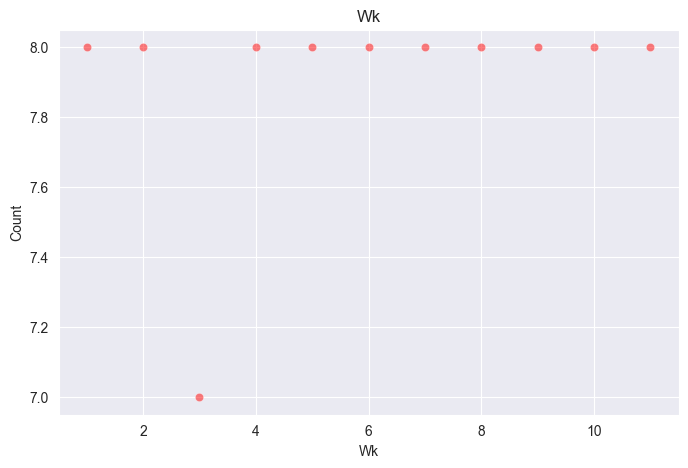

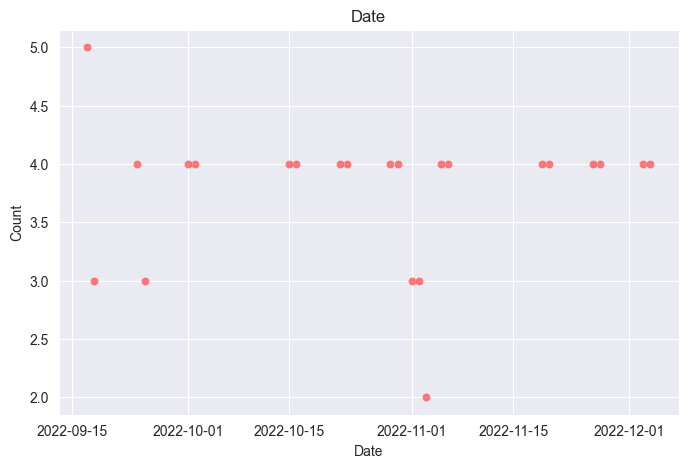

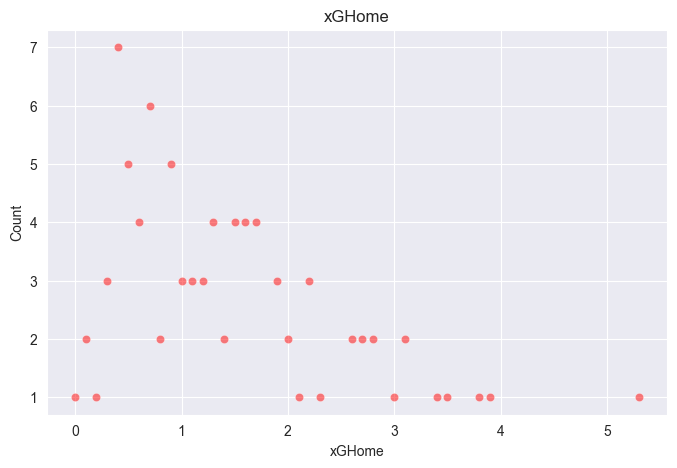

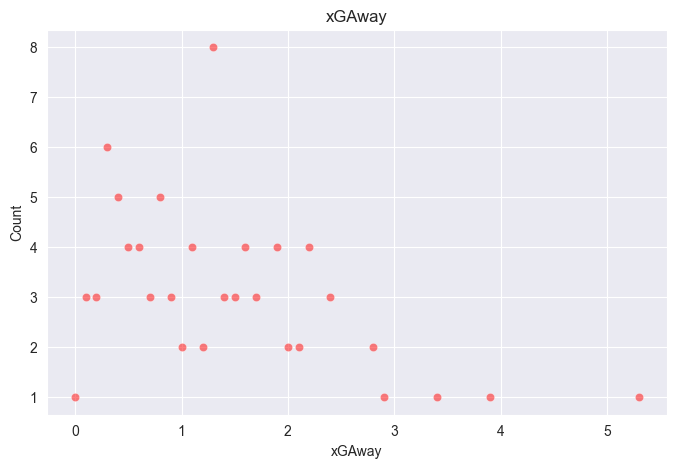

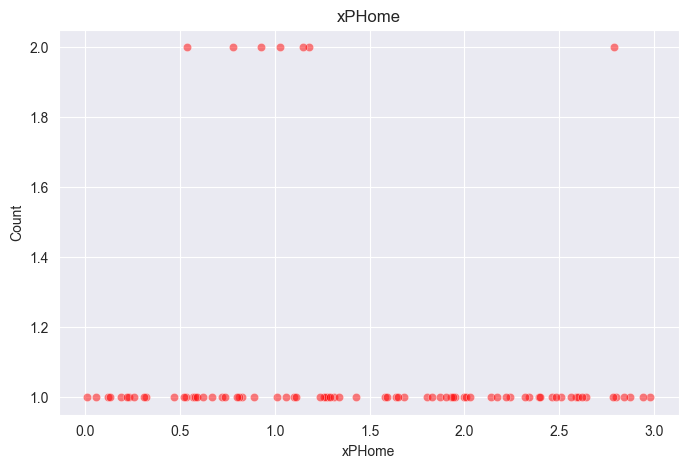

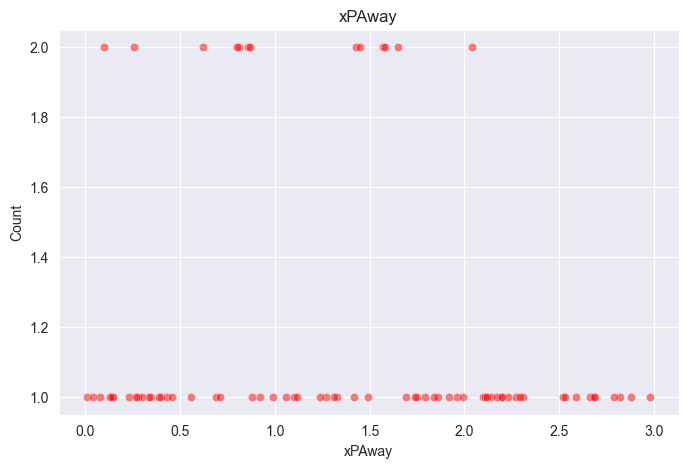

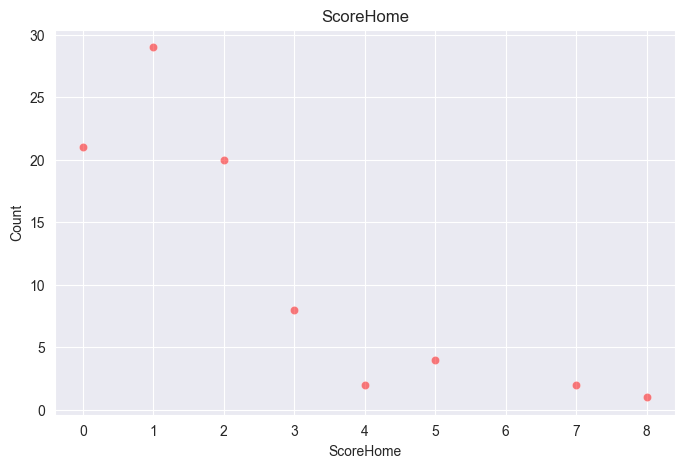

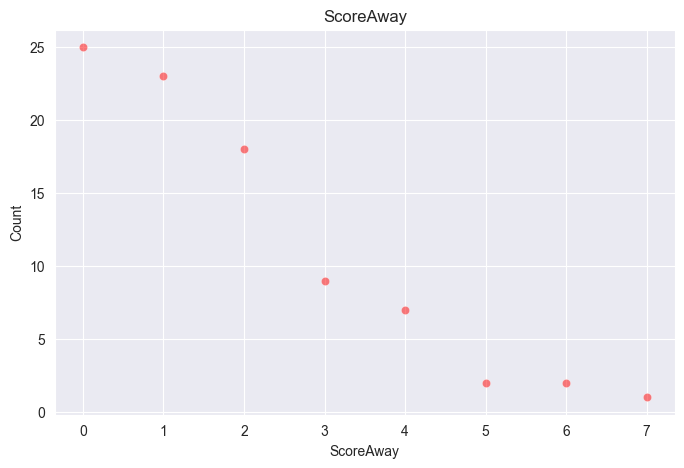

"# Plot the missing values in columns with missing values as a histogram\nplt.figure(figsize=(15, 5))\n\nplt.title('Count of missing values in columns')\nplt.xlabel('Columns')\nplt.ylabel('Missing values')\nplt.xticks(rotation=90)\nplt.ylim(0,5)\n\nsns.barplot(x=matches.columns, y=matches.isnull().sum(), fill=None, linewidth=1)\n\nplt.show()"

In [5]:
# Get the count of missing values in each column
display(matches.isnull().sum())

# Plot single variable scatterplots
for column in matches.columns:
    # if column type is object, skip it
    if matches[column].dtype == 'object':
        continue
    plt.figure(figsize=(8, 5))

    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Count')

    sns.scatterplot(x=matches[column].value_counts().index, y=matches[column].value_counts(), color='red', alpha=0.5)

    plt.show()
"""# Plot the missing values in columns with missing values as a histogram
plt.figure(figsize=(15, 5))

plt.title('Count of missing values in columns')
plt.xlabel('Columns')
plt.ylabel('Missing values')
plt.xticks(rotation=90)
plt.ylim(0,5)

sns.barplot(x=matches.columns, y=matches.isnull().sum(), fill=None, linewidth=1)

plt.show()"""

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
61,8,Sun,2022-11-06,16:00:00,Sevilla,1.4,5–0,0.8,Levante Planas,1.80,0.92,5,0
34,6,Sat,2022-10-22,18:15:00,Real Betis,0.0,0–3,2.8,Barcelona,0.06,2.88,0,3
62,8,Sun,2022-11-06,18:00:00,Real Madrid,0.4,0–4,3.4,Barcelona,0.12,2.82,0,4
37,6,Sun,2022-10-23,16:00:00,Valencia,1.5,1–1,0.6,Levante Planas,2.03,0.71,1,1


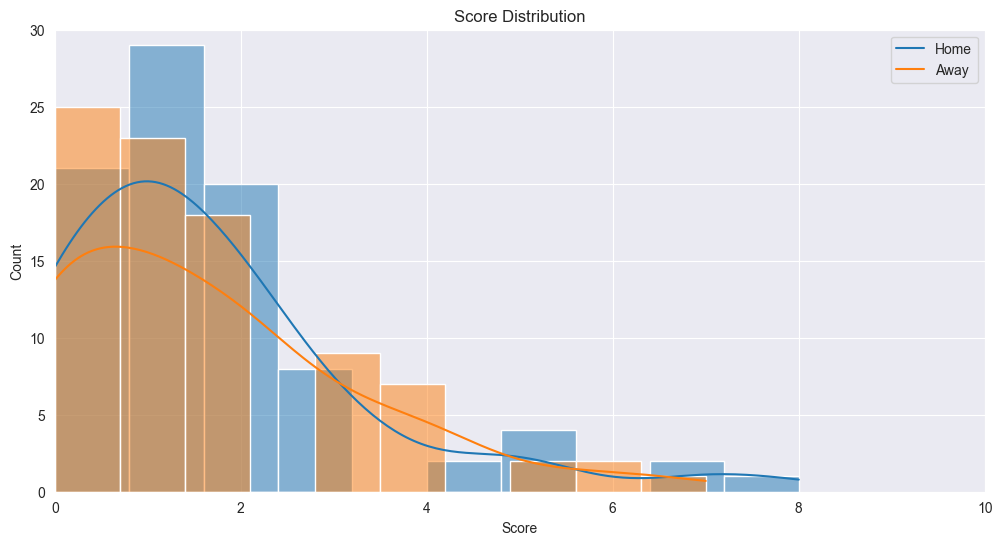

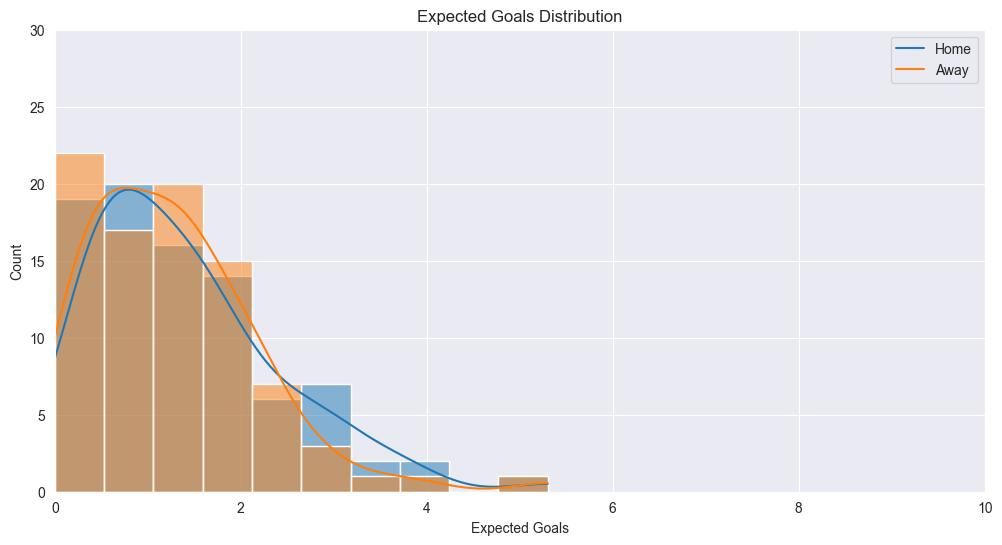

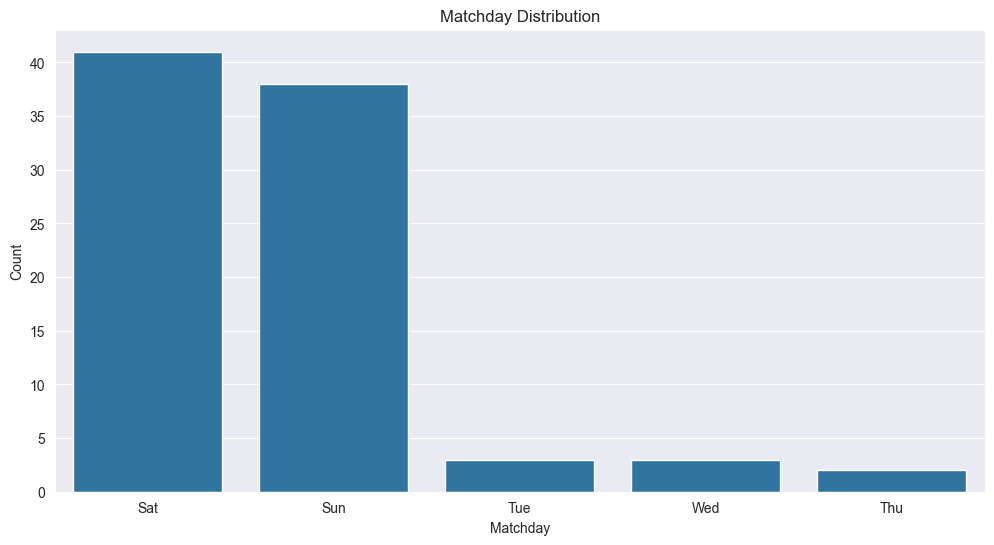

In [6]:
# Explore the statistical properties of the data, structure, features, etc.
display(matches.sample(4))

# Histogram of scores in seaborn
plt.figure(figsize=(12,6))
sns.histplot(matches['ScoreHome'], kde=True, stat='count', bins=10)
sns.histplot(matches['ScoreAway'], kde=True, stat='count', bins=10)

plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() 

# Histogram of Expected Goals in seaborn
plt.figure(figsize=(12,6))
sns.histplot(matches['xGHome'], kde=True, stat='count', bins=10)
sns.histplot(matches['xGAway'], kde=True, stat='count', bins=10)

plt.title('Expected Goals Distribution')
plt.xlabel('Expected Goals')
plt.ylabel('Count')
plt.legend(['Home', 'Away'])
plt.xlim(0, 10)
plt.ylim(0, 30)

plt.show() # Expected goals are more normally distributed than actual goals

# Barplot of Match days in seaborn
plt.figure(figsize=(12,6))
sns.barplot(x=matches['Day'].value_counts().index, y=matches['Day'].value_counts().values)

plt.title('Matchday Distribution')
plt.xlabel('Matchday')
plt.ylabel('Count')

plt.show()

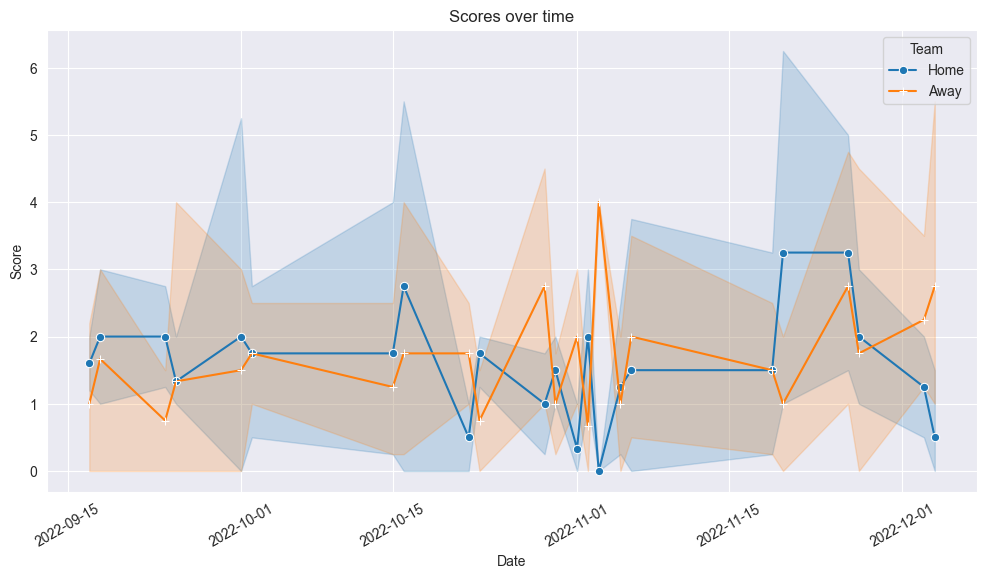

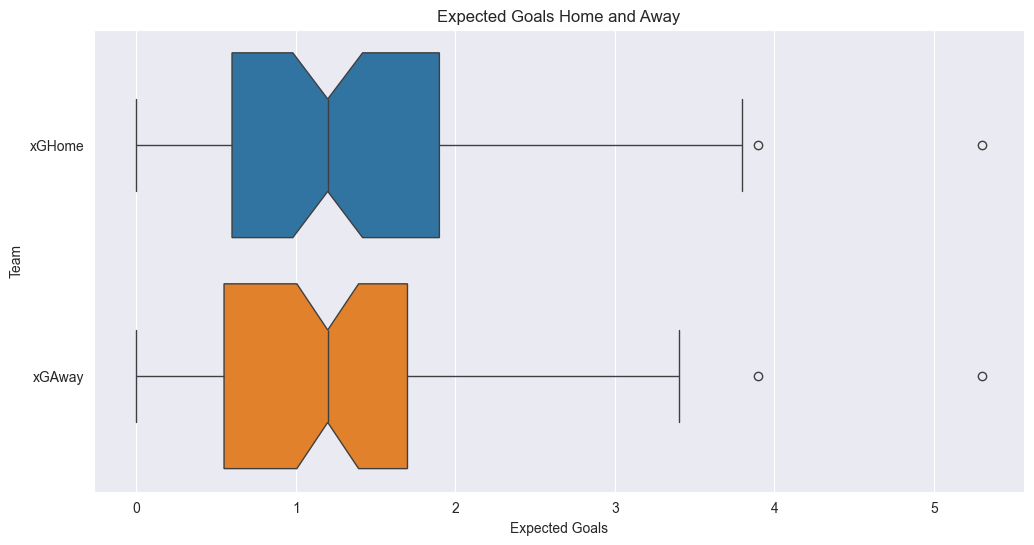

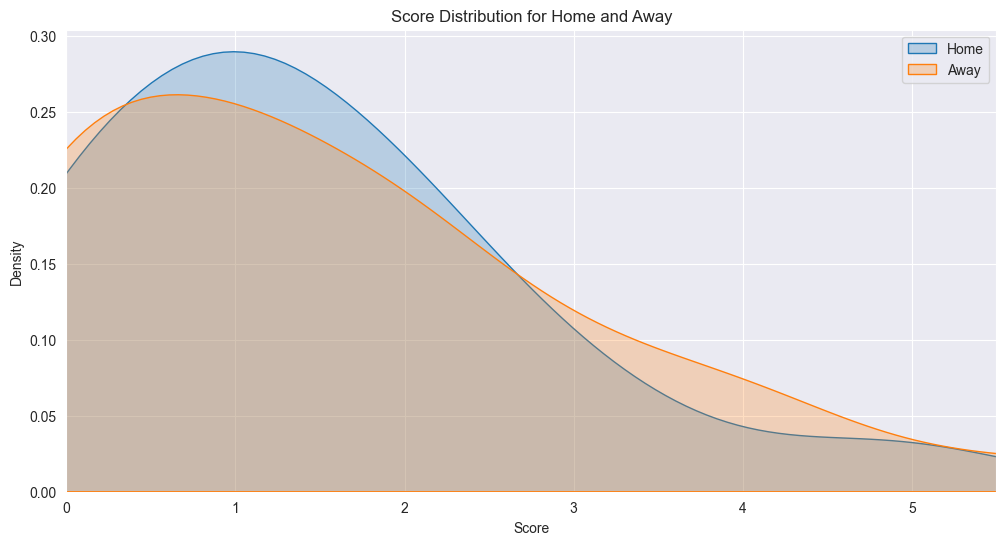

In [7]:
# LinePlot of Scores over time in seaborn
plt.figure(figsize=(12,6))

sns.lineplot(markers=True, marker='o', x='Date', y='ScoreHome', data=matches, label='Home')
sns.lineplot(markers=True, marker='+', x='Date', y='ScoreAway', data=matches, label='Away')

plt.xticks(rotation=30)
plt.title('Scores over time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(title='Team')

plt.show()

# Boxplot of Expected Goals Home and Away wo show the distribution of the data
plt.figure(figsize=(12,6))

sns.boxplot(data=matches[['xGHome', 'xGAway']], notch=True, orient='h')

plt.title('Expected Goals Home and Away')
plt.xlabel('Expected Goals')
plt.ylabel('Team')

plt.show()
# ------------------------------------------------- Same as above but with the kdeplot
plt.figure(figsize=(12,6))

sns.kdeplot(x=matches['ScoreHome'], shade=True)
sns.kdeplot(x=matches['ScoreAway'], shade=True)

plt.title('Score Distribution for Home and Away')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(['Home', 'Away'])
plt.xlim(0, 5.5)

plt.show()

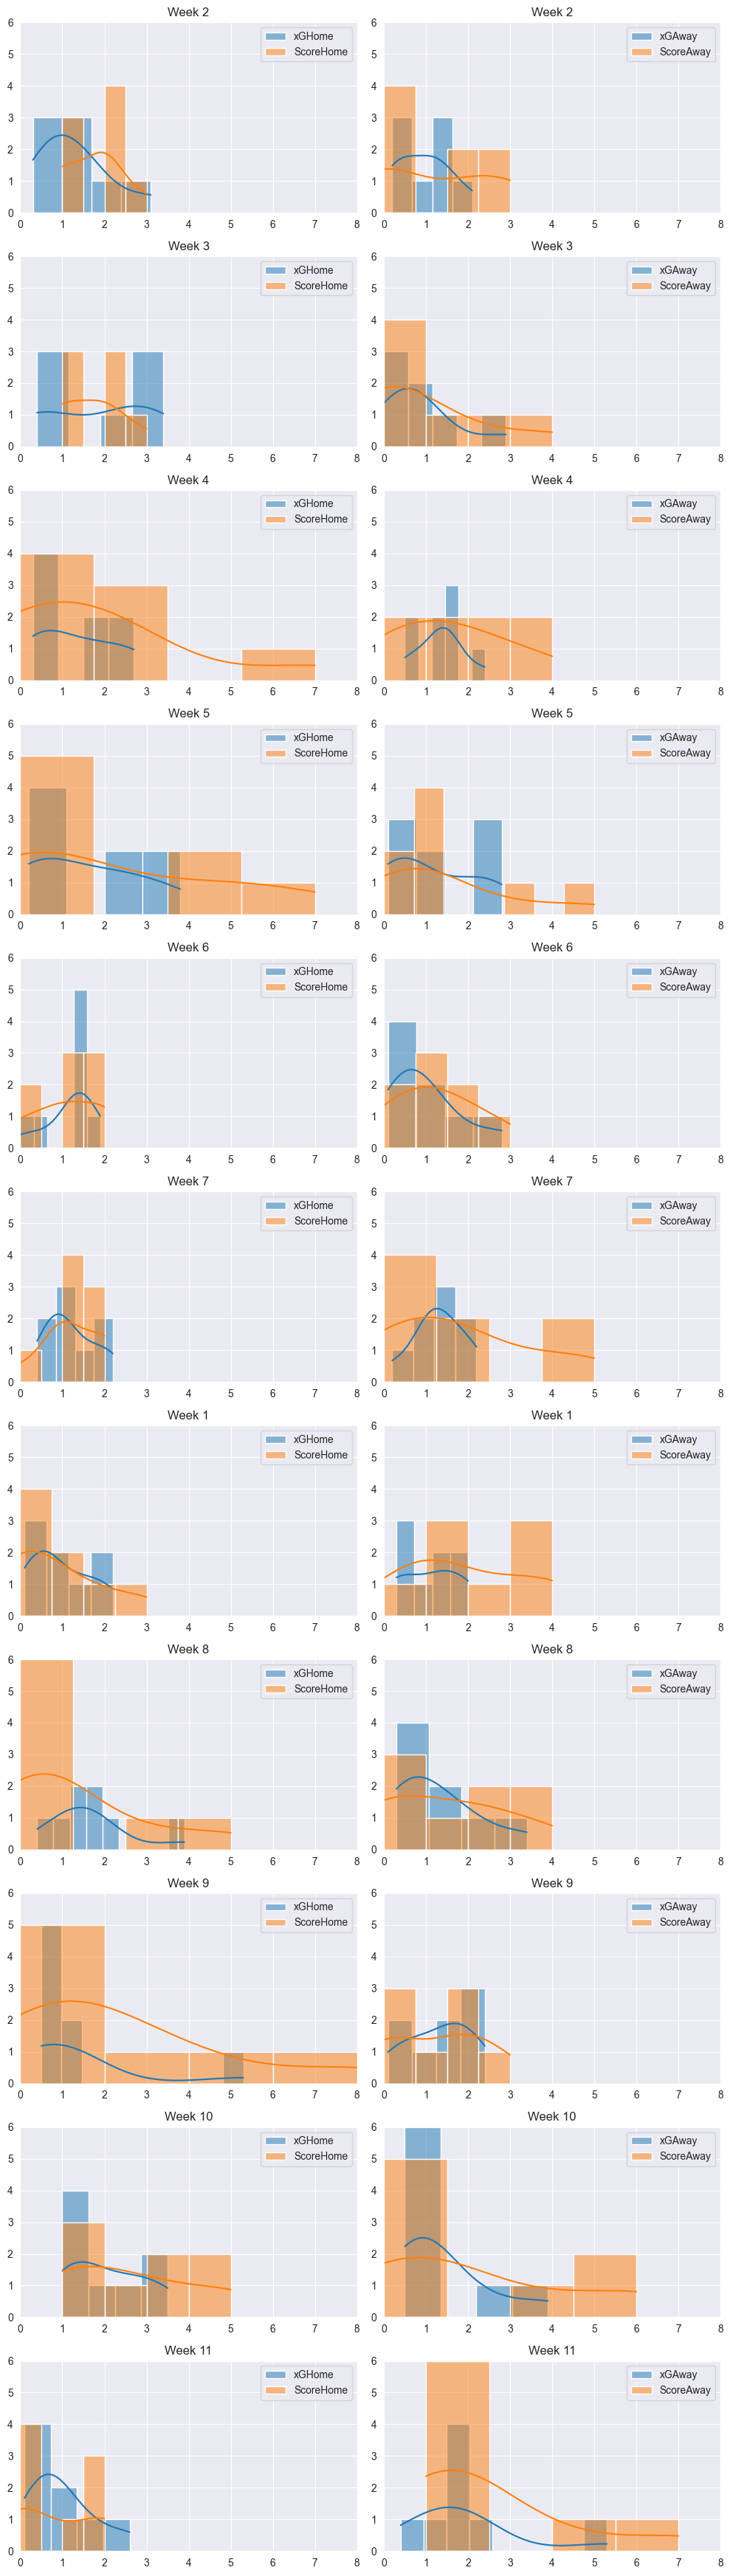

In [8]:
# Does the distribution of scores change as the weeks go by?
plt.figure(figsize=(10, 35))

integer_columns = ['xGHome', 'ScoreHome', 'xGAway', 'ScoreAway']
weeks = matches['Wk'].unique()
num_weeks = len(weeks)
num_cols = len(integer_columns) // 2

for i, week in enumerate(weeks):
    plt.subplot(num_weeks, num_cols, i*num_cols+1)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[:2]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    plt.subplot(num_weeks, num_cols, i*num_cols+2)
    plt.ylim(0, 6)
    plt.xlim(0, 8)
    for col in integer_columns[2:]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.tight_layout()
plt.show()

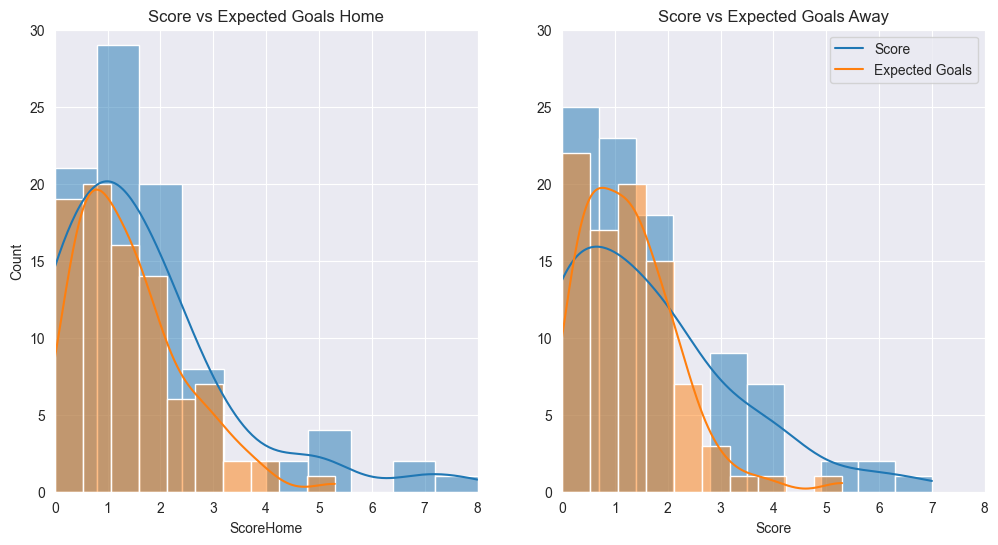

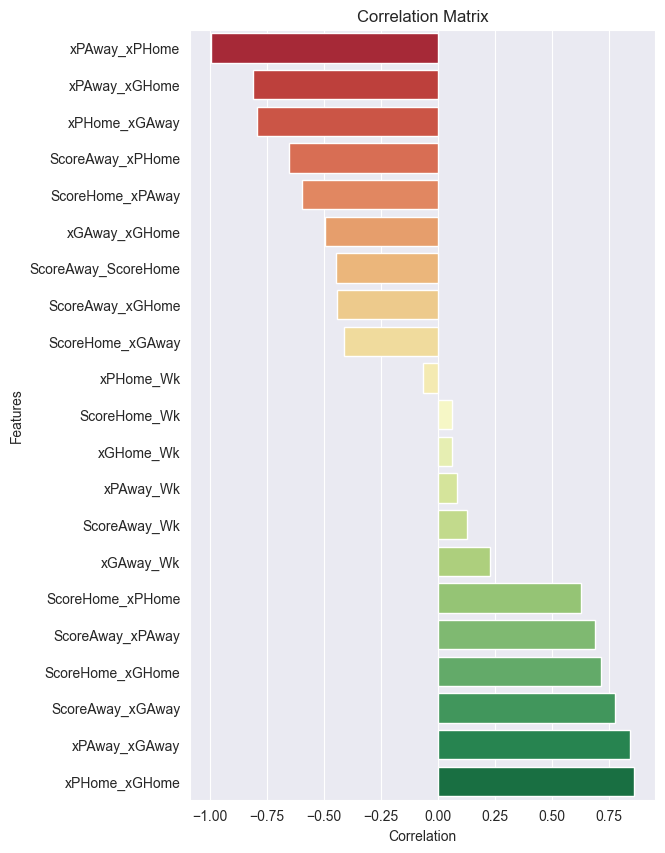

In [9]:
# Is there a correlation between the expected goals and the actual goals?
plt.figure(figsize=(12,6))

for i, col in enumerate(['Home', 'Away']):
    plt.subplot(1, 2, i+1)

    plt.xlim(0, 8)
    plt.ylim(0, 30)
    
    sns.histplot(x=f'Score{col}', data=matches,  kde=True, stat='count', bins=10)
    sns.histplot(x=f'xG{col}', data=matches,  kde=True, stat='count', bins=10)
    
    plt.title(f'Score vs Expected Goals {col}')

plt.xlabel('Score')
plt.ylabel('')
plt.legend(['Score', 'Expected Goals'])

plt.show() 

# Plot the correlation matrix
numeric_columns = matches.select_dtypes(include=np.number).columns
correlations = matches[numeric_columns].corr()
columns = correlations.columns
rows = correlations.index

corresponding = []
correlations_list = []

for col in columns:
    for row in rows:
        corresponding.append(row+'_'+col)

correlations = correlations.values.flatten()

for idx, value in enumerate(corresponding):
    correlations_list.append([value, correlations[idx]])   

processed_labels = set()
labels = []
values = []

for label, value in sorted(correlations_list, key=lambda x: x[1]):
    reverse_label = '_'.join(label.split('_')[::-1])
    
    if label not in processed_labels and reverse_label not in processed_labels and label != reverse_label:
        labels.append(label)
        values.append(value)
        processed_labels.add(label)

sorted_labels, sorted_values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))


plt.figure(figsize=(6,10))

norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.barplot(y=sorted_labels, x=sorted_values, palette=sns.color_palette('RdYlGn', len(sorted_labels)), order=sorted_labels)

plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation Matrix')

plt.show()

# Feature Engineering

In [10]:
# Create interaction terms: Multiplication of 2 features which have a joint effect on the target variable to create a new feature that captures this effect.
interaction_terms = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_var   = interaction_terms.fit_transform(matches[['xGHome', 'xGAway']])


In [11]:
# Encode Categorical Features
categorical_columns = matches.select_dtypes(include='object').columns #['Day', 'Time', 'Home', 'Score', 'Away']
useful_categorical  = categorical_columns.drop('Score')

matches['Numeric_Day'] = matches['Day'].apply(lambda x: 2 if x == 'Tue' else 3 if x == 'Wed' else 4 if x == 'Thu' else 6 if x == 'Sat' else 7) # Encode the Day column
display(matches['Time'].value_counts()) # I was going to ignore the Time column

encoder = LabelEncoder()
matches['Numeric_Home'] = encoder.fit_transform(matches['Home'])
matches['Numeric_Away'] = encoder.transform(matches['Away']) # Use the same encoder as the Home column"""

encoder_time = OrdinalEncoder()
matches['Numeric_Time'] = encoder_time.fit_transform(matches['Time'].values.reshape(-1, 1)) # Ignore the first column to avoid the dummy variable trap


Time
12:00:00    32
16:00:00    19
18:00:00     9
18:15:00     7
19:00:00     4
11:00:00     4
17:00:00     2
20:00:00     2
21:00:00     2
14:00:00     2
17:45:00     1
11:45:00     1
18:45:00     1
16:30:00     1
Name: count, dtype: int64

In [12]:
# Add the interaction terms to the matches dataframe
matches_encoded = pd.concat([matches, pd.DataFrame(interaction_var, columns=['i_t1', 'i_t2', 'i_t3'])], axis=1)

# display(matches_encoded.sample(3), matches_encoded.info(), matches_encoded.shape)

# Drop the categorical columns
matches_encoded = matches_encoded.select_dtypes(include=['int64', 'float64'])
display(matches_encoded.sample(3))


,Wk,xGHome,xGAway,xPHome,xPAway,ScoreHome,ScoreAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time,i_t1,i_t2,i_t3
23,5,0.3,2.2,0.26,2.59,1,1,6,6,5,2.0,0.3,2.2,0.66
40,7,1.9,0.2,2.56,0.27,2,0,6,7,13,2.0,1.9,0.2,0.38
14,3,0.4,0.4,1.24,1.24,2,0,7,5,2,11.0,0.4,0.4,0.16


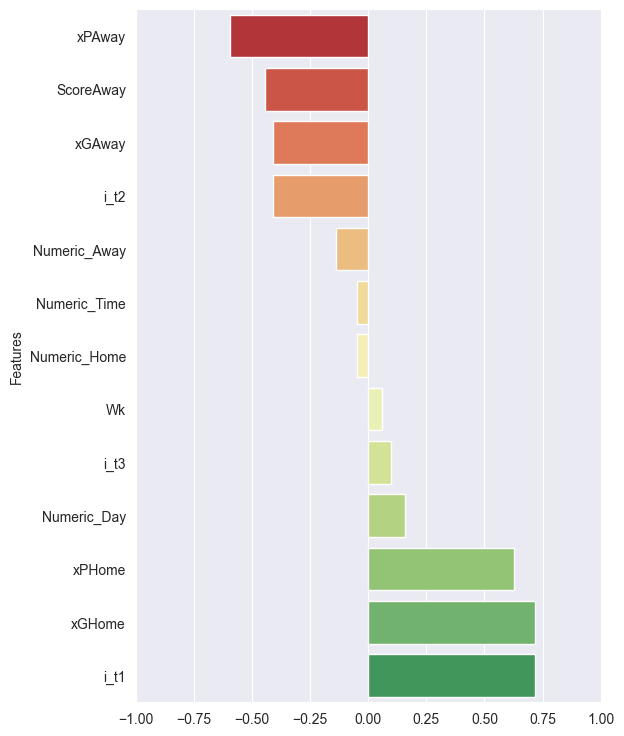

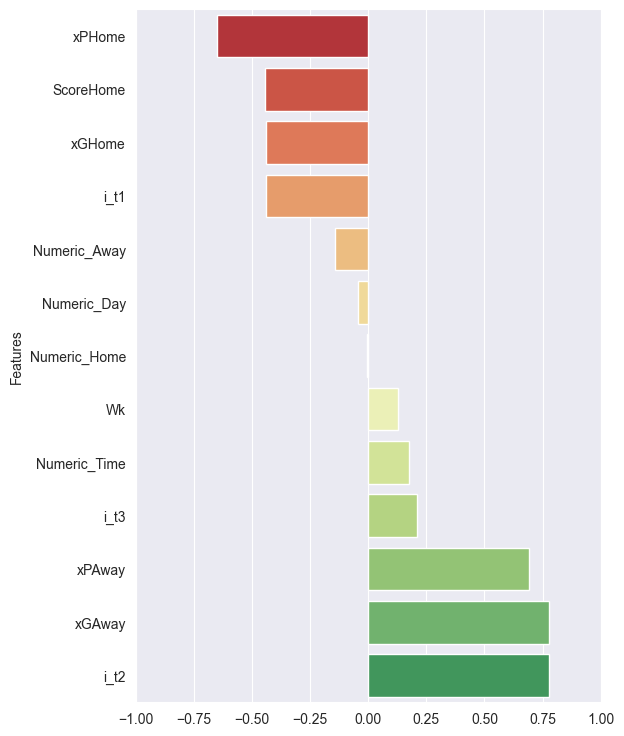

In [13]:
# What features have the highest correlation with the target variable?
correlations_home = matches_encoded.corr().sort_values(['ScoreHome']).ScoreHome
correlations_away = matches_encoded.corr().sort_values(['ScoreAway']).ScoreAway

# display(correlations_home, correlations_away)

norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

plt.figure(figsize=(6,9))
sns.barplot(y=correlations_home[:-1].keys(), x=correlations_home[:-1].values, palette=sns.color_palette('RdYlGn', len(correlations_home)))

plt.xlim(-1, 1)
plt.ylabel('Features vs ScoreHome')
plt.show()

plt.figure(figsize=(6,9))
sns.barplot(y=correlations_away[:-1].keys(), x=correlations_away[:-1].values, palette=sns.color_palette('RdYlGn', len(correlations_away)))

plt.xlim(-1, 1)
plt.ylabel('Features vs ScoreAway')
plt.show()

# Model Building

## Baseline Model

In [14]:
X = matches_encoded.drop(columns=['ScoreHome', 'ScoreAway'])
y = matches_encoded[['ScoreHome']].squeeze() # 'ScoreAway'

display(X.sample(3), y.sample(3))

,Wk,xGHome,xGAway,xPHome,xPAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time,i_t1,i_t2,i_t3
0,2,1.9,0.4,2.40,0.40,6,4,13,2.0,1.9,0.4,0.76
42,7,1.0,1.3,1.15,1.57,6,1,8,9.0,1.0,1.3,1.30
14,3,0.4,0.4,1.24,1.24,7,5,2,11.0,0.4,0.4,0.16


82    1
58    3
53    0
Name: ScoreHome, dtype: int64

In [15]:
display(matches_encoded.sample(3))
# Split the data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size=.6, 
                                                  random_state=42) 
                                    # Next time, try to predict the away score
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    train_size=.5, 
                                                    random_state=42)

,Wk,xGHome,xGAway,xPHome,xPAway,ScoreHome,ScoreAway,Numeric_Day,Numeric_Home,Numeric_Away,Numeric_Time,i_t1,i_t2,i_t3
81,11,0.8,1.9,0.67,2.11,0,2,6,2,7,4.0,0.8,1.9,1.52
66,9,0.6,1.3,0.80,1.92,1,3,6,2,10,12.0,0.6,1.3,0.78
31,6,0.6,1.1,0.93,1.74,1,1,6,0,2,2.0,0.6,1.1,0.66


In [16]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [17]:
model_eval = pd.DataFrame(columns=['Model','Training MSE', 'Validation MSE', 'Training R2', 'Validation R2'])
param_grid = [
    {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
        }
    },
    {
        'model': KernelRidge(),
        'params':{
            'alpha':[0.1, 0.5, 1, 5, 10],
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'degree':[2, 3, 4, 5],
            'coef0':[0.1, 0.5, 1, 5, 10]
        }
    },{
        'model': GradientBoostingRegressor(),
        'params':{
            'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
            'max_depth': [5, 10, 15, 20],
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [5, 2, 4],
            'loss': ['ls', 'lad', 'huber', 'quantile']
        }
    },{
        'model': LGBMRegressor(),
        'params':{
            'objective':['regression'],
            'num_leaves':[5, 10, 15, 20, 25, 30],
            'learning_rate':[0.01, 0.05, 0.1, 0.5, 1],
            'n_estimators':[100, 200, 300, 400, 500],
            'max_bin':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'bagging_fraction':[0.5, 0.75, 1],
            'bagging_freq':[5, 10, 15, 20],
            'feature_fraction':[0.5, 0.75, 1],
            'feature_fraction_seed':[5, 10, 15, 20],
            'bagging_seed':[5, 10, 15, 20],
            'min_data_in_leaf':[5, 10, 15, 20],
            'min_sum_hessian_in_leaf':[5, 10, 15, 20]
        }
    },{
        'model':SVR(),
        'params': {
            'C': [0.1, 0.5, 1, 5, 10],
            'epsilon': [0.01, 0.05, 0.1, 0.5, 1],
            'gamma': ['scale', 'auto'],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
},{
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'colsample_bytree': [0.5, 0.75, 1],
            'max_depth': [5, 10, 15, 20],
            'reg_alpha': [0.1, 0.5, 1],
            'reg_lambda': [0.1, 0.5, 1],
            'subsample': [0.5, 0.75, 1],
            'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
            'booster': ['gbtree', 'gblinear', 'dart'],
            'objective': ['reg:logistic', 'reg:squarederror']
        }
    },
    {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20],
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [5, 2, 4],
            'criterion': ['mse', 'mae']
        }
    }] 
def tune_hyperparameters(idx):
    model = param_grid[idx]['model']
    params = param_grid[idx]['params']

    classifier = GridSearchCV(model,
                              params,
                              cv=5,
                              return_train_score=True,
                              verbose=0,
                              n_jobs=-1)
    # classifier.fit(X_train, y_train)
    return classifier


In [22]:
n_iterations = 50

"""
TODO::
    - Optimize this function so it runs faster and doesn't take up so much memory
"""
def plot_loss_fxn(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, n_iterations=n_iterations, idx= 0):
    global model_eval
    model = tune_hyperparameters(idx)

    # if model.__class__.__name__ == 'SVR':
    #     X_train = StandardScaler().fit_transform(X_train)
    #     X_val = StandardScaler().fit_transform(X_val)
    mse_train = []
    mse_val   = []
    r2_train  = []
    r2_val    = []
    y_train_pred = []

    for epoch in range(n_iterations):
        clear_output(wait=True)

        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        curr_mse_train = mean_squared_error(y_train, y_train_pred)
        curr_mse_val   = mean_squared_error(y_val, y_val_pred)
        
        curr_r2_train  = r2_score(y_train, y_train_pred)
        curr_r2_val    = r2_score(y_val, y_val_pred)
        
        mse_train.append(curr_mse_train)
        mse_val.append(curr_mse_val)  
        r2_train.append(curr_r2_train) 
        r2_val.append(curr_r2_val)   
        
        plt.figure(figsize=(14,6))
        
        plt.xlim(0, n_iterations)
        plt.ylim(-1, 5)
        
        plt.plot(r2_val, linewidth=.8, label='Validation R2')
        plt.plot(mse_val, linewidth=.8, label='Validation MSE')
        plt.plot(r2_train, linewidth=.8, label='Training R2')
        plt.plot(mse_train, linewidth=.8, label='Training MSE')
        
        plt.legend()
        plt.xlabel(f'mse train: {curr_mse_train:.4f} | mse val: {curr_mse_val:.4f} | r2 train: {curr_r2_train:.4f} | r2 val: {curr_r2_val:.4f}')
        plt.title(f'Model: {model.__class__.__name__} | Best Score: {model.best_score_} | Best Params: {model.best_estimator_}\n Epoch: {epoch+1}/{n_iterations}\n Training R2: {curr_r2_train:.4f} | Validation R2: {curr_r2_val:.4f}\n Training MSE: {curr_mse_train:.4f} | Validation MSE: {curr_mse_val:.4f}')
        # plt.pause(1.2)
        
        plt.savefig(f'airflow/dags/assets/{model.best_estimator_.__class__.__name__}_loss_fxn.png', bbox_inches='tight', pad_inches=0.5, dpi=300, format='png')
        
        plt.show()
    
    plt.figure(figsize=(14,6))
    
    sns.scatterplot(x=y_train.index, y=y_train.values.flatten(), label='Actual')
    # plt.hlines(y=y_train_pred.flatten(), xmin=y_train.index.min(), xmax=y_train.index.max(), colors='red', label='Predicted')
    sns.scatterplot(x=y_train.index, y=y_train_pred.flatten(), label='Predicted')
    # plt.hlines(y=y_train.values.flatten(), xmin=y_train.index.min(), xmax=y_train.index.max(), colors='red', label='Actual')
    
    plt.title(f'Model: {model.__class__.__name__}\n Actual vs Predicted Scores')
    # plt.xlabel(f'accuracy {accuracy_score(y_train, y_train_pred):.4f} | precision {precision_score(y_train, y_train_pred):.4f} | recall {recall_score(y_train, y_train_pred):.4f} | f1 {f1_score(y_train, y_train_pred):.4f}')
    
    plt.savefig(f'airflow/dags/assets/{model.best_estimator_.__class__.__name__}_actual_vs_predicted.png', bbox_inches='tight', pad_inches=0.5, dpi=300, format='png')
    
    plt.show()
    
    new_row = {'Model': model.__class__.__name__, 
               'Training MSE': curr_mse_train, 
               'Validation MSE': curr_mse_val,
               'Training R2': curr_r2_train,
               'Validation R2': curr_r2_val}
    model_eval = pd.concat([model_eval, 
                            pd.DataFrame([new_row])], 
                           ignore_index=True)

### Explanation of the r2-score.
The R2 score is a statistical measure that determines if the linear regression predictions approximate the actual data.
- A value of 1 indicates that the regression predictions perfectly fit the data.
- A value of 0 indicates that the regression predictions do not fit the data.
- A value of -1 indicates that the regression predictions fit the data but in the opposite direction.
- 0>R2>1 indicates the amount of variance in the target variable that is explained by the model.

AdaBoostRegressor:
    + The high r2 score shows that the model is a good fit for the training data.
    + The r2 score of ~.25 shows the model is not a good fit for the validation data.

XGBRegressor:
    + The high r2 score shows that the model is a good fit for the training data.
    + The r2 score of .33 shows the model is not a good fit for the validation data.
    
LGBMRegressor:
    + The r2 score of 0 shows that the model is not a good fit for the training data.
    + The -ve r2 score of -.01 shows the model is an opposite fit for the validation data.

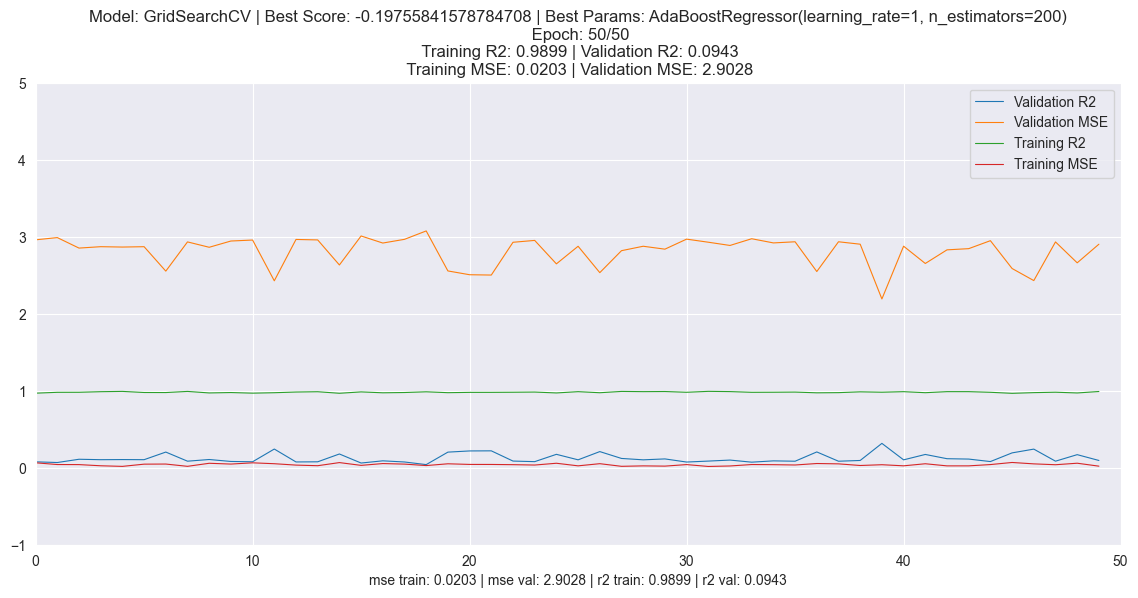

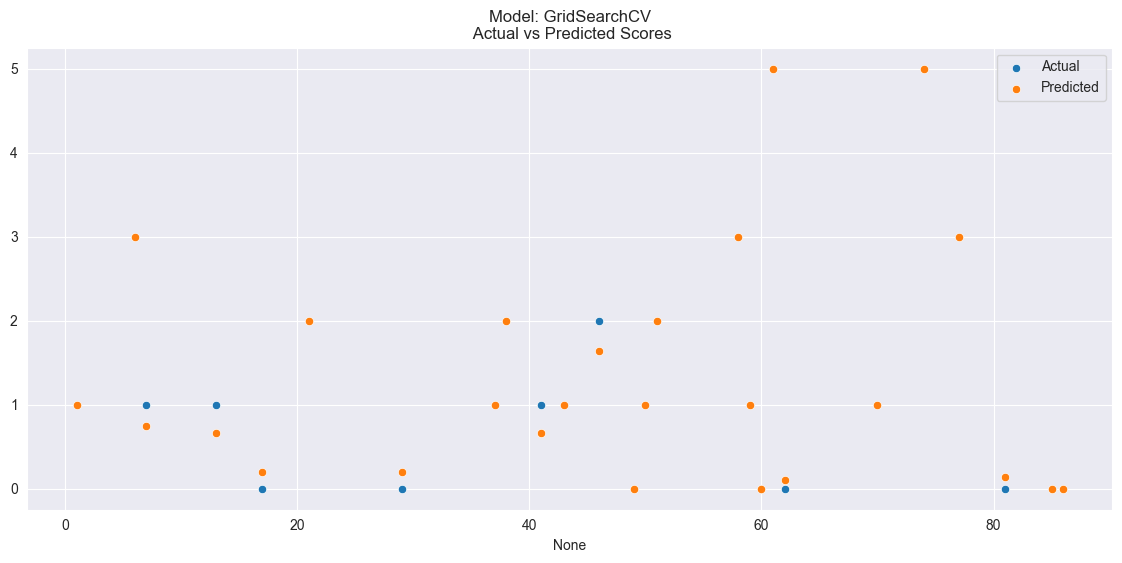

In [23]:
plot_loss_fxn(idx=0)


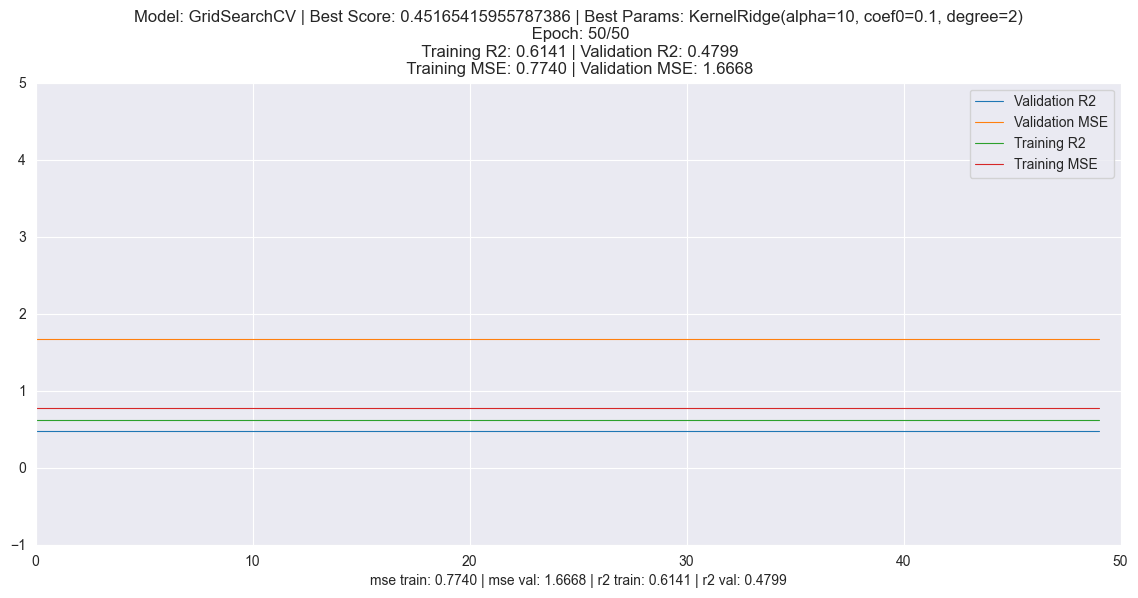

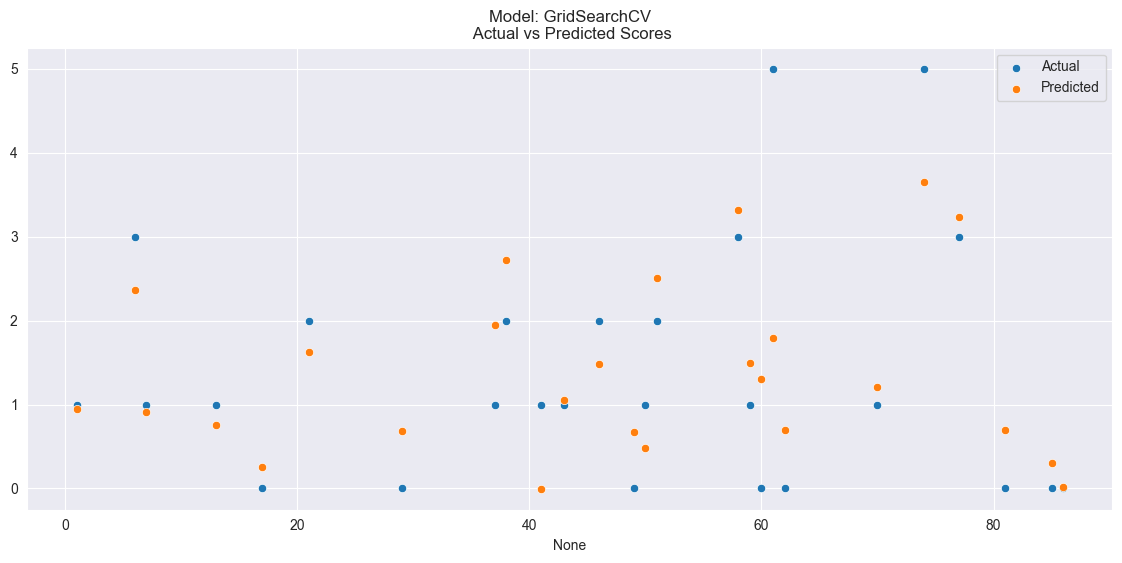

In [24]:
plot_loss_fxn(idx=1)


In [25]:
plot_loss_fxn(idx=2)


KeyboardInterrupt: 

In [ ]:
plot_loss_fxn(idx=3)


In [ ]:
plot_loss_fxn(idx=4)


In [ ]:
display(model_eval)

# Airflow and SQLite

- Save the model and its parameters and metrics into an sqlite database using an airflow pipeline
- Split the notebook into python file(s) # Documentation
- How to run serve the model?